# Quantization Techniques for Reducing Large Model Size

## Introduction

Modern transformer models such as **BERT** and **LLaMA** contain millions or billions of parameters.  
The size of a neural network model depends mainly on:

- Number of parameters (N)
- Precision (bit-width) used to store each parameter


$$
\text{Model Size (bytes)} = \frac{N \times b}{8}
$$

Where:
- N = number of parameters  
- b = number of bits per parameter  

For example:

$$
\text{FP32: } b=32 \Rightarrow 4N \text{ bytes}
$$

$$
\text{INT8: } b=8 \Rightarrow N \text{ bytes}
$$

Reducing (b) significantly reduces memory consumption.


`why quantization ?`

* Quantization is the process of mapping continuous values to a discrete set of values, reducing the number of bits required to represent each parameter
*  it convert from a high memory format to a lower memory format
*   FP32 -> Full Percision & FP16 / BF16 -> Half Percision
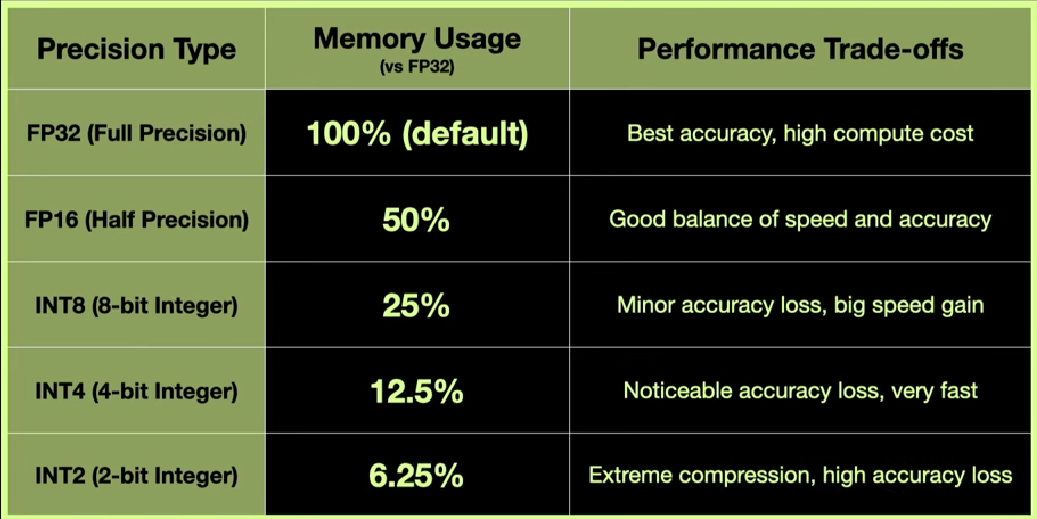



##  common Data types
-  Float32 (FP32): The IEEE 32-bit floating-point format includes 8 bits for the exponent, 23 bits for the mantissa, and 1 bit for the sign.
   - It provides high precision but has a significant computational and memory footprint
---
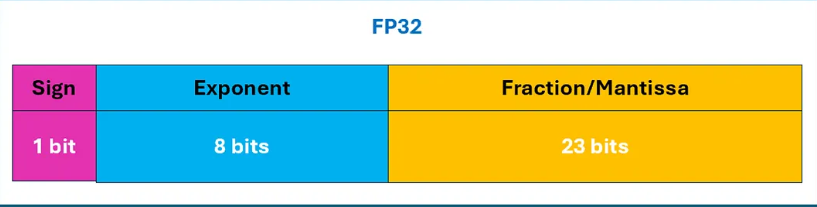
---
- Float16 (FP16): This format has 5 bits for the exponent and 10 bits for the mantissa
    - This can increase the risk of overflow with large numbers and underflow with small numbers.

- bfloat16 (BF16): This format uses 8 bits for the exponent and 7 bits for the mantiss
    - aoffers a broader range than FP16 and reducing underflow and overflow risks. Despite having fewer significand bits and slightly lower precision

# common lower data types
- INT8
- INT4

## Quantization Formulation

The quantization function is defined as:

$$
Q(r) = \mathrm{round}\left(\frac{r}{S} + Z \right)
$$

Where:

- \( r \) : real (floating-point) value  
- \( S \) : scale factor  
- \( Z \) : zero-point  
- \( Q(r) \) : quantized integer value  



## Scale Factor

The scale is computed as:

$$
S = \frac{\beta - \alpha}{\beta_q - \alpha_q}
$$

Where:

- $[\alpha, \beta]$ : real input range  
- $[\alpha_q, \beta_q]$ : quantized integer range

For **8-bit quantization**:

$$
\beta_q - \alpha_q = 2^8 - 1 = 255
$$


## Zero-Point

The zero-point is computed as:

$$
Z = \alpha_q - \frac{\alpha}{S}
$$

The purpose of \( Z \) is to ensure that:

$$
r = 0 \Rightarrow Q(r) = 0
$$


## Dequantization

To approximately recover the real value:

$$
\hat{r} = S (Q(r) - Z)
$$






##  Scale Computation

Given real value range:

$$
x_{\min}, x_{\max}
$$

Scale is computed as:

$$
s = \frac{x_{\max} - x_{\min}}{q_{\max} - q_{\min}}
$$

Zero-point:

$$
z = q_{\min} - \frac{x_{\min}}{s}
$$

---

## Integer Range

For signed \( b \)-bit quantization:

$$
q_{\min} = -2^{b-1}
$$

$$
q_{\max} = 2^{b-1} - 1
$$

For unsigned quantization:

$$
q_{\min} = 0
$$

$$
q_{\max} = 2^b - 1
$$

---

Quantization offers a solution by reducing precision:

$$\text{Compression Ratio} = \frac{b_{\text{original}}}{b_{\text{quantized}}}$$

where $b$ represents bit-width. For FP32 → INT8:

$$\text{Compression} = \frac{32}{8} = 4\times$$

# Quantization Types (Two General Categories)


## Post-Training Quantization (PTQ)

Post-Training Quantization is applied after the model has been fully trained in FP32.

It involves converting weights and potentially activations from higher precision to lower precision.

Common methods include static and dynamic quantization.

The original trained weights $ ( W \in \mathbb{R} ) $ are converted to low precision:

$$
W \rightarrow Q(W)
$$

### Characteristics:

- No retraining required
- Fast and easy to apply
- May cause small accuracy degradation


# Quantization-Aware Training (QAT)

Quantization-Aware Training simulates quantization during training

Instead of training with full precision:

$$
W_{fp32}
$$

we train using a fake-quantized version:

$$
W_{fake} = S \left( \mathrm{round}\left(\frac{W}{S} \right) \right)
$$

This offers better performance than PTQ, as the model learns to reduce quantization errors during train

In [1]:
# Quantization Example
import numpy as np

weights = np.array([0.12, -0.45, 1.33, -2.1, 0.78])

# 8-bit range
qmin, qmax = -128, 127

# Compute scale and zero point
min_val, max_val = weights.min(), weights.max()
scale = (max_val - min_val) / (qmax - qmin)
zero_point = int(qmin - min_val / scale)

# Quantize
quantized = np.clip(np.round(weights / scale + zero_point), qmin, qmax)

# Dequantize
dequantized = scale * (quantized - zero_point)

print("Original:", weights)
print("Quantized:", quantized)
print("Dequantized:", dequantized)


Original: [ 0.12 -0.45  1.33 -2.1   0.78]
Quantized: [  37.   -5.  127. -128.   86.]
Dequantized: [ 0.12105882 -0.44388235  1.33164706 -2.09835294  0.78015686]


In [2]:
# PyTorch Dynamic Quantization (BERT)
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model_fp32 = AutoModelForSequenceClassification.from_pretrained(model_name)
model_fp32.eval()

# Apply Dynamic Quantization
model_int8 = torch.quantization.quantize_dynamic(model_fp32,{torch.nn.Linear},dtype=torch.qint8)

text = "Quantization reduces memory usage."
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output_fp32 = model_fp32(**inputs).logits
    output_int8 = model_int8(**inputs).logits

print("FP32 logits:", output_fp32[0][:5])
print("INT8 logits:", output_int8[0][:5])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/tmp/ipython-input-696332986.py:12: D

FP32 logits: tensor([0.2057, 0.4180])
INT8 logits: tensor([0.2865, 0.4629])


In [3]:
import os
import tempfile

def get_model_size(model):
    with tempfile.NamedTemporaryFile(delete=False) as f:
        torch.save(model.state_dict(), f.name)
        size_mb = os.path.getsize(f.name) / (1024**2)
    os.remove(f.name)
    return size_mb

print("FP32 size:", get_model_size(model_fp32), "MB")
print("INT8 size:", get_model_size(model_int8), "MB")

FP32 size: 417.7237939834595 MB
INT8 size: 173.08754062652588 MB


# BitsAndBytes Quantization (LLM 8-bit & 4-bit)

Large Language Models (LLMs) like LLaMA and Mistral are too large
to fit in standard GPU memory using FP32.

## 8-bit Quantization

Weights are stored as INT8 instead of FP32:

$$
\text{Memory Reduction} \approx \frac{32}{8} = 4\times
$$

---

## 4-bit Quantization (NF4)

NF4 = NormalFloat4

Instead of uniform quantization:

$$
q = \mathrm{round}\left(\frac{r}{S} + Z \right)
$$

NF4 uses non-uniform quantization optimized for normally distributed weights.

Memory reduction:

$$
\frac{32}{4} = 8\times
$$

---



In [4]:
pip install -U bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.7 MB/s eta 0:00:00


In [12]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_id = "facebook/opt-125m"

tokenizer = AutoTokenizer.from_pretrained(model_id)

torch.cuda.empty_cache()

model_fp32 = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    device_map="auto"
)

print("FP32 GPU memory (MB):",
      torch.cuda.memory_allocated() / 1024**2)

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.decoder.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


FP32 GPU memory (MB): 884.10888671875


In [13]:
del model_fp32
torch.cuda.empty_cache()

bnb_8 = BitsAndBytesConfig(load_in_8bit=True)

model_8bit = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_8,
    device_map="auto"
)

print("8-bit GPU memory (MB):",
      torch.cuda.memory_allocated() / 1024**2)


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.decoder.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


8-bit GPU memory (MB): 491.42529296875


In [14]:
del model_8bit
torch.cuda.empty_cache()

bnb_4 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4"
)

model_4bit = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_4,
    device_map="auto"
)

print("4-bit GPU memory (MB):",
      torch.cuda.memory_allocated() / 1024**2)


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.decoder.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


4-bit GPU memory (MB): 305.34912109375
